# Problem Statement

We need to build a model that is able to classify Customer Complaints based on the products/services. By doing so you can segregate these tickets into their relevant categories.

As data is not labeled, apply NMF to analyse patterns and classify the tickets into the following 5 clusters based on the products/services.

- **Credit/Prepaid Card**
- **Bank Account Services**
- **Theft/Dispute Reporting**
- **Mortgages/Loans**
- **Others**

# Import Required Libraries and Modules

In [76]:
# Builtin libraries
import os
import warnings
import json
import re
import string
import IPython as ipy
import pickle
import pprint

# libraries for machine learning 
import numpy as np
import pandas as pd
import matplotlib as mpl 
import seaborn as sns
import plotly
import sklearn as skl 
import json

# NLP libraries
import nltk
import spacy
import en_core_web_sm
import textblob
import wordcloud
import gensim
import string

In [77]:
warnings.filterwarnings(action='ignore')

In [78]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from matplotlib import pyplot as plt 

from sklearn.model_selection import train_test_split as tts 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import decomposition as decomp

from plotly import offline as plot
from plotly import graph_objects as go
from plotly import express as px

from pprint import pprint

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora.dictionary import Dictionary
from gensim.models import nmf, CoherenceModel 
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [81]:
# nlp_model = en_core_web_sm.load()

# Loading Input (JSON) Data as DataFrame

In [82]:
with open("./Client_data.json") as f_handle:
    input_data = json.load(f_handle)
input_df = pd.json_normalize(input_data)
input_df.head(3)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


# EDA

In [83]:
#Size of the dataset
input_df.shape

(78313, 22)

In [84]:
#Information about the dataframe (column names,column length, datatypes and if they contain null records)
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

#### *Observation: We see non-null values for every column. Column '_source.company_public_response'  has only 4 records so can be ignored for further exploration.*

In [85]:
input_df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [86]:
#Choosing only the necessary columns - '_source.product','_source.sub_product','_source.complaint_what_happened' from source dataframe

complain_df = input_df[['_source.product','_source.sub_product','_source.complaint_what_happened']]
complain_df.shape

(78313, 3)

In [87]:
#Renaming the columns

complain_df = complain_df.rename(columns={'_source.complaint_what_happened': 'Complaint', '_source.product': 'Category','_source.sub_product': 'Sub_Category' })
complain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Category      78313 non-null  object
 1   Sub_Category  67742 non-null  object
 2   Complaint     78313 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [88]:
complain_df.head()

,Category,Sub_Category,Complaint
0,Debt collection,Credit card debt,
1,Debt collection,Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage,Conventional home mortgage,
4,Credit card or prepaid card,General-purpose credit card or charge card,


#### *Observation: We see that the column 'Sub_Category' contains some null values so replacing them with nan.There are a few records with missing values. We will drop them.*

In [89]:
#Dropping missing values

complain_df.dropna(inplace=True)
complain_df.shape

(67742, 3)

In [90]:
#Replacing the blank comments with Nan

complain_df = complain_df.replace(r'^\s*$', np.nan, regex=True)

In [91]:
complain_df.head()

,Category,Sub_Category,Complaint
0,Debt collection,Credit card debt,NaN
1,Debt collection,Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage,Conventional home mortgage,NaN
4,Credit card or prepaid card,General-purpose credit card or charge card,NaN


#### *Observation: The dataype is object for Complaint column. Converting it to string datatype.There are 'XXX' in some complaints. Replacing it with ''.*

In [92]:
complain_df['Complaint']=complain_df['Complaint'].astype(str)
complain_df['Complaint'] = complain_df['Complaint'].str.replace('X', '')

In [93]:
import nltk, spacy, string

In [94]:
# nlp = spacy.load('en_core_web_sm')

In [95]:
import re
#Cleaning Text- This function will convert text in lower case, removing text in square brackets, removing punctuations, removing words containing numbers
def processtext(issue_df):
    issue_df=issue_df.lower()
    issue_df=re.sub(r'\[.*?\]',"",issue_df)
    issue_df=re.sub(r'\w*\d\w*',"",issue_df)
    issue_df=re.sub(r'[%s]'% re.escape(string.punctuation),"",issue_df)
    return issue_df.strip()

complain_df['Complaints_Clean']=complain_df['Complaint'].apply(lambda x:processtext(x))


In [96]:
# # Function to create lemmatized text
# def text_lemma(complaint):
#     sent=[]
#     doc=nlp(complaint)
#     for word in doc:
#         sent.append(word.lemma_)
#     return " ".join(sent)

# complain_df['Complains_Lemmatized']= complain_df.apply(lambda x:text_lemma(x['Complaints_Clean']),axis=1)

In [97]:
complain_df

,Category,Sub_Category,Complaint,Complaints_Clean
0,Debt collection,Credit card debt,nan,nan
1,Debt collection,Credit card debt,Good morning my name is and I appreciate it ...,good morning my name is and i appreciate it ...
2,Credit card or prepaid card,General-purpose credit card or charge card,I upgraded my card in //2018 and was told by...,i upgraded my card in and was told by the a...
3,Mortgage,Conventional home mortgage,nan,nan
4,Credit card or prepaid card,General-purpose credit card or charge card,nan,nan
...,...,...,...,...
78307,Mortgage,Conventional home mortgage,nan,nan
78308,Checking or savings account,Checking account,nan,nan
78309,Credit card or prepaid card,General-purpose credit card or charge card,"On Wednesday, // I called Chas, my Visa Cred...",on wednesday i called chas my visa credit c...
78310,Checking or savings account,Checking account,I am not familiar with pay and did not unders...,i am not familiar with pay and did not unders...


In [98]:
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation

In [99]:
def text_lemma(texts):
    # tokenization
    texts = [re.findall(r'\w+', line.lower()) for line in texts]
    # remove stopwords
    texts = [remove_stopwords(' '.join(line)).split() for line in texts]
    # remove punctuation
    texts = [strip_punctuation(' '.join(line)).split() for line in texts]
    # remove words that are only one or two characters
    texts = [[token for token in line if len(token) >2] for line in texts]
    # remove numbers
    texts = [[token for token in line if not token.isnumeric()] for line in texts]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    texts = [[word for word in lemmatizer.lemmatize(' '.join(line), pos='v').split()] for line in texts]

    return texts

In [101]:
complain_df['Complains_Lemmatized']= complain_df.apply(lambda x:text_lemma(x['Complaints_Clean']),axis=1)


## Vizualization of Issues

In [102]:
complain_df.Complains_Lemmatized

0                                             [[], [], []]
1        [[], [], [], [], [], [], [], [], [], [], [], [...
2        [[], [], [], [], [], [], [], [], [], [], [], [...
3                                             [[], [], []]
4                                             [[], [], []]
                               ...                        
78307                                         [[], [], []]
78308                                         [[], [], []]
78309    [[], [], [], [], [], [], [], [], [], [], [], [...
78310    [[], [], [], [], [], [], [], [], [], [], [], [...
78311    [[], [], [], [], [], [], [], [], [], [], [], [...
Name: Complains_Lemmatized, Length: 67742, dtype: object

(-0.5, 399.5, 199.5, -0.5)

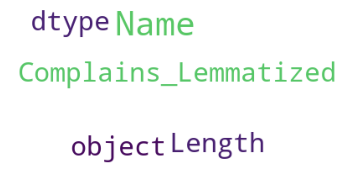

In [103]:
#Word Cloud

from wordcloud import WordCloud, STOPWORDS

wordcloud= WordCloud(collocations = False, 
                     background_color = 'white', 
                     stopwords=set(STOPWORDS), 
                     max_words=40, 
                     max_font_size=40, 
                     random_state=42).generate(str(complain_df['Complains_Lemmatized']))

fig=plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [104]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [105]:
top_30words = ngrams(complain_df['Complains_Lemmatized'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

ValueError: setting an array element with a sequence

## Vectorizing data and using NMF

In [ ]:
#TF-IDF
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [ ]:
#Creating document term matrix
doc_term_matrix = tfidf.fit_transform(complain_df['Complains_Lemmatized'])

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
#Load nmf model with the n_components = 5
num_topics = 5

#keeping the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40)

#NMF model
nmf_model.fit(doc_term_matrix)
len(tfidf.get_feature_names())

In [ ]:
H1 = nmf.components_

In [ ]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

#### *Observation: The below topics are apparent as main topics.**

- **1.   Banking  Services
- **2.   Card
- **3.   Others
- **4.   Fraudalent Reporting
- **5.   Loans

In [ ]:
#Mapping topic names and Topics
Topic_names = {0:"Banking services",1:"Cards", 2:"Others",3:"Fraudalent Reporting",4:"Loans"}

#Map Topics with Topic Names
complain_df['Topic_names'] = complain_df['Topic'].map(Topic_names)



## Training the model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
# Import pickle to save and load the model
import pickle

In [ ]:
#Training dataset
train_df=complain_df[["Complains_Lemmatized","Topic"]]

#Count Vectorizer
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(complain_df['Complains_Lemmatized'])
# Save word vector
pickle.dump(vect.vocabulary_, open("complain_count_vector.pkl", "wb"))

#TFIDF transformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)
# Save tfidf
pickle.dump(tfidf_transformer, open('complain_tfidf.pkl', "wb"))

In [ ]:
## Test train split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, train_data.Topic, test_size=0.20, random_state=42)

In [ ]:
# Multinomial Naive Bayes for classification
clf = MultinomialNB().fit(X_train, y_train)

In [ ]:
# Logistic regression model
reg_models = LogisticRegression(random_state=44).fit(X_train,y_train)
reg_models.score(X_test,y_test)

In [ ]:
# Decision tree classifier
decision_tree_classifier =  DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
decision_tree_classifier.score(X_test,y_test)

In [ ]:
# Random forest classifier
random_forest_classifier = RandomForestClassifier(random_state=42).fit(X_train, y_train)
random_forest_classifier.score(X_test, y_test)